# Classification of low/high confidence in Iowa Gambling Task

In [2]:
import os
import pip
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import seaborn as sns
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import pickle
from nilearn.masking import apply_mask, unmask
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker

/usr/bin/python


In [3]:
# Define the base data directory
data_dir = os.path.join(os.path.expanduser('/work/fMRI_data/BIDS_2024E'), 'derivatives')
print("Data directory:", data_dir)

# Dictionaries to store relevant files for each subject
anat_data = {}
func_data = {}

# Loop through all folders in the derivatives directory that start with "sub-XXXX" and are directories
for subject_folder in sorted(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject_folder)
    if subject_folder.startswith("sub-") and os.path.isdir(subject_path):  # Ensure it's a directory
        # Define the session folder path
        ses_dir = os.path.join(subject_path, 'ses-001')
        
        # Define paths for anat and func folders within each session
        anat_dir = os.path.join(ses_dir, 'anat')
        func_dir = os.path.join(ses_dir, 'func')
        
        # Store anat data paths if folder exists
        if os.path.exists(anat_dir):
            anat_data[subject_folder] = sorted(os.listdir(anat_dir))
        
        # Load functional data
        if os.path.exists(func_dir):
            # Initialize subject-specific dictionaries for func data
            func_data[subject_folder] = {}
            
            # Define paths for BOLD, brain mask, and confounds files
            bold_file = [f for f in os.listdir(func_dir) if 'desc-preproc_bold.nii.gz' in f]
            confounds_file = [f for f in os.listdir(func_dir) if 'desc-confounds_timeseries.tsv' in f]
            brain_mask_file = [f for f in os.listdir(func_dir) if f.endswith('desc-brain_mask.nii.gz')]  # Search for exact mask filename ending

            # Load confounds data if the file is present
            if confounds_file:
                confounds_path = os.path.join(func_dir, confounds_file[0])
                confounds_df = pd.read_csv(confounds_path, sep='\t')
                func_data[subject_folder]['confounds'] = confounds_df

            # Store BOLD and brain mask paths if files are present
            if bold_file:
                bold_path = os.path.join(func_dir, bold_file[0])
                func_data[subject_folder]['bold'] = bold_path
            
            if brain_mask_file:  # Check and assign brain mask if found
                brain_mask_path = os.path.join(func_dir, brain_mask_file[0])
                func_data[subject_folder]['brain_mask'] = brain_mask_path

# Print out loaded data structure for verification
print("Anatomical Data:", anat_data)
print("Functional Data:", func_data)


Data directory: /work/fMRI_data/BIDS_2024E/derivatives
Anatomical Data: {'sub-0136': ['sub-0136_ses-001_acq-T1sequence_run-1_desc-brain_mask.json', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-brain_mask.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-preproc_T1w.json', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-preproc_T1w.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_dseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5', 'sub-0136_ses-001_acq-T1sequence_run-1_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5', 'sub-0136_ses-001_acq-T1sequence_run-1_label-CSF_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_label-GM_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_label-WM_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.json', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152

In [4]:
import nibabel as nib

# Load the fMRI image
fmri_img_path = func_data["sub-0136"]["bold"] 
fmri_img = nib.load(fmri_img_path)

# Get the spatial dimensions (x, y, z) and the number of time points (t)
x_voxels, y_voxels, z_voxels, time_points = fmri_img.shape

# Get voxel dimensions (in mm)
voxel_dims = fmri_img.header.get_zooms()  # Returns a tuple of (x, y, z, t) in mm and seconds

# Print the information
print(f"The fMRI images contain {x_voxels} voxels in the x-axis, {y_voxels} voxels in the y-axis, "
      f"{z_voxels} voxels in the z-axis, and {time_points} time points, with the spatiotemporal dimensions of "
      f"({voxel_dims[0]}mm, {voxel_dims[1]}mm, {voxel_dims[2]}mm, {voxel_dims[3]}s) in millimetres (mm) and seconds (s).")


The fMRI images contain 78 voxels in the x-axis, 92 voxels in the y-axis, 78 voxels in the z-axis, and 600 time points, with the spatiotemporal dimensions of (2.5260000228881836mm, 2.5260000228881836mm, 2.5mm, 1.0s) in millimetres (mm) and seconds (s).


In [5]:
# Define the base directory for events data and load behavioral data
events_data_dir = os.path.expanduser('/work/fMRI_data/BIDS_2024E')
behavioral_data = pd.read_csv("/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/in/detailed_confidence_data.csv")

# Initialize a dictionary to store each subject's merged DataFrame
subject_events_data = {}

# Process each subject folder to collect and merge events with behavioral data
for subject_folder in sorted(os.listdir(events_data_dir)):
    if not subject_folder.startswith("sub-"):
        continue

    # Identify subject numeric ID
    subj_numeric_id = int(subject_folder.split('-')[1])
    
    # Define path to session's functional data folder
    ses_dir = os.path.join(events_data_dir, subject_folder, 'ses-001', 'func')
    if not os.path.isdir(ses_dir):
        continue

    # Initialize a list to gather DataFrames for each session
    subject_data_list = []
    
    # Process each event file in the session directory
    for event_file in filter(lambda f: f.endswith("events.tsv"), os.listdir(ses_dir)):
        event_path = os.path.join(ses_dir, event_file)
        events_df = pd.read_csv(event_path, sep='\t')

        # Filter to include only "decks" trial type
        events_df = events_df[events_df['trial_type'] == 'decks']

        # Extract run (session) number and filter behavioral data accordingly
        run_number = int(event_file.split('_')[3].split('-')[1])
        behavioral_subset = behavioral_data[
            (behavioral_data['subject_id'] == subj_numeric_id) &
            (behavioral_data['session'] == run_number)
        ][['onset_decks', 'confidence']]
        
        # Merge events with behavioral data based on onset times
        merged_df = events_df.merge(
            behavioral_subset, how='left', left_on='onset', right_on='onset_decks'
        ).loc[:, ['onset', 'duration', 'confidence']]  # Retain only necessary columns
        
        # Add the session (run) number as a column
        merged_df['session'] = run_number

        # Map confidence to HC and LC, generate trial_type with subject ID and session
        def generate_trial_type(row, trial_idx):
            expression = "HighConf" if row['confidence'] == 2 else "LowConf"
            return f"tt_{str(trial_idx).zfill(2)}ID{subj_numeric_id}SES{run_number}STIM{expression}"

        # Apply the function to generate the trial_type for each trial in the DataFrame
        merged_df['trial_type'] = [
            generate_trial_type(row, idx) for idx, row in merged_df.iterrows()
        ]
        
        # Append this session's DataFrame to the list
        subject_data_list.append(merged_df)
    
    # Concatenate all session DataFrames for the subject
    subject_events_data[subj_numeric_id] = pd.concat(subject_data_list, ignore_index=True)

# Now subject_events_data includes session numbers and updated trial_type IDs with session information.


In [6]:
# Example
subject_events_data[136]

,onset,duration,confidence,session,trial_type
0,1.004390,5.0,2,3,tt_00ID136SES3STIMHighConf
1,15.985176,5.0,2,3,tt_01ID136SES3STIMHighConf
2,31.019258,5.0,2,3,tt_02ID136SES3STIMHighConf
3,46.019909,5.0,2,3,tt_03ID136SES3STIMHighConf
4,61.020791,5.0,1,3,tt_04ID136SES3STIMLowConf
...,...,...,...,...,...
155,526.038804,5.0,2,2,tt_35ID136SES2STIMHighConf
156,541.039531,5.0,2,2,tt_36ID136SES2STIMHighConf
157,556.040207,5.0,1,2,tt_37ID136SES2STIMLowConf
158,571.041003,5.0,2,2,tt_38ID136SES2STIMHighConf


In [ ]:
# Output directory
output_dir = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'
os.makedirs(output_dir, exist_ok=True)

# Loop over each subject in func_data
for participant_id, files in func_data.items():
    try:
        print(f"Processing {participant_id}...")

        # Check if all necessary files are available
        if not ('bold' in files and 'confounds' in files and 'brain_mask' in files):
            print(f"Data for participant {participant_id} is missing necessary files.")
            continue

        # Define the mask and functional image paths
        func_path = files["bold"]
        mask_path = files["brain_mask"]

        # Load the functional image and mask
        func_img = nib.load(func_path)
        mask_img = nib.load(mask_path)

        # Step 1: Normalize the functional image by dividing each voxel's time series by its mean
        func_data = func_img.get_fdata()
        mean_img_data = func_data.mean(axis=-1)
        mean_img_data[mean_img_data == 0] = 1e-8
        normalized_func_data = func_data / mean_img_data[..., np.newaxis]
        normalized_func_img = nib.Nifti1Image(normalized_func_data, func_img.affine, func_img.header)

        print("Functional image normalized.")

        # Step 2: Initialize and fit the FirstLevelModel with the normalized data
        flm_face = FirstLevelModel(
            t_r=0.7,
            slice_time_ref=0.5,
            mask_img=mask_img,
            hrf_model='glover',
            drift_model='cosine',
            high_pass=0.01,
            smoothing_fwhm=None,
            minimize_memory=True,
            noise_model='ols'
        )

        # Load event and confound data
        subj_numeric_id = int(participant_id.split('-')[1])
        events_df = subject_events_data[subj_numeric_id]
        confounds_cleaned = files['confounds'].loc[:, ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
        confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')

        # Fit the model with normalized functional data
        flm_face.fit(normalized_func_img, events=events_df, confounds=confounds_cleaned)
        print(f"Model fitting completed for {participant_id}.")

        # Save the fitted model
        model_path = os.path.join(output_dir, f'{participant_id}_flm_model.pkl')
        with open(model_path, 'wb') as model_file:
            pickle.dump(flm_face, model_file)

        # Step 3: Compute and standardize contrast values
        R_face_subject = []
        for col in events_df['trial_type']:
            img = flm_face.compute_contrast(col, output_type='effect_size')
            img_data = np.squeeze(img.get_fdata())

            if img_data.shape == mask_img.shape:
                # Apply mask and standardize
                masked_data = apply_mask(nib.Nifti1Image(img_data, img.affine), mask_img)
                masked_data = zscore(masked_data)
                R_face_subject.append(masked_data)
                print(f"Applied mask and standardized contrast for trial '{col}'")
            else:
                print(f"Error: Adjusted contrast image shape {img_data.shape} does not match mask shape {mask_img.shape} for trial '{col}'")
                continue

        # Stack and save contrast data
        if R_face_subject:
            R_face_subject = np.vstack(R_face_subject)
            contrast_path = os.path.join(output_dir, f'{participant_id}_R_face.npy')
            np.save(contrast_path, R_face_subject)
            print(f"Successfully stacked and saved all trials for {participant_id} with shape: {R_face_subject.shape}")

            # Check standardized contrast statistics
            print("Standardized Contrast Mean:", np.mean(R_face_subject))
            print("Standardized Contrast Standard Deviation:", np.std(R_face_subject))

            # Save the first trial visualization as a sanity check
            img_test = unmask(R_face_subject[0, :], mask_img)
            fig = plotting.plot_glass_brain(img_test, cmap='blue_red', colorbar=True, plot_abs=False, vmin=-3, vmax=3)
            fig.savefig(os.path.join(output_dir, f'{participant_id}_first_trial_plot.png'))
            fig.close()
        else:
            print(f"No valid trials found to stack for {participant_id}.")

    except Exception as e:
        print(f"An error occurred while processing {participant_id}: {e}")


In [6]:
# Define paths
out_folder = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'
subject_id = "sub-0140"  # Replace with your subject ID if needed

# Load the R_face data for the subject
r_face_path = os.path.join(out_folder, f'{subject_id}_R_face.npy')
R_face = np.load(r_face_path)

In [7]:
# Import necessary modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.neural_network import MLPClassifier
import os

# Define paths
out_folder = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'

# Load the R_face data for all subjects
all_R_face = []
all_confidence_labels = []

num_files = len([f for f in os.listdir(out_folder) if f.endswith('_R_face.npy')])
current_file = 0
for file_name in os.listdir(out_folder):
    if file_name.endswith('_R_face.npy'):
        current_file += 1
        subject_id = file_name.split('_')[0]
        r_face_path = os.path.join(out_folder, file_name)
        R_face = np.load(r_face_path)
        all_R_face.append(R_face)

        # Confidence levels are binary (e.g., 0 for Low Confidence, 1 for High Confidence)
        confidence_labels = []
        for col in subject_events_data.get(int(subject_id.split('-')[1]), {}).get('confidence', []):
            confidence_labels.append(1 if col == 2 else 0)
        all_confidence_labels.extend(confidence_labels)

In [8]:
# Combine all subjects' data
# Ensure all arrays have the same number of features (voxel counts)
min_features = min(arr.shape[1] for arr in all_R_face)
all_R_face = [arr[:, :min_features] for arr in all_R_face]
all_R_face = np.vstack(all_R_face)
all_confidence_labels = np.array(all_confidence_labels)

In [9]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_R_face, all_confidence_labels, test_size=0.2, random_state=42)

In [10]:
#  Neural Network Classifier (MLP)
mlp_model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(150, 100, 50), activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', max_iter=1000, random_state=42, early_stopping=True, n_iter_no_change=20, verbose=True))
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
print("Neural Network (MLP) Classifier:")
print(f"Accuracy: {accuracy_mlp:.2f}")
print(f"ROC-AUC Score: {roc_auc_mlp:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Iteration 1, loss = 3.32620808
Validation score: 0.610390
Iteration 2, loss = 2.84114526
Validation score: 0.649351
Iteration 3, loss = 2.50134382
Validation score: 0.597403
Iteration 4, loss = 2.22746655
Validation score: 0.597403
Iteration 5, loss = 1.62217041
Validation score: 0.558442
Iteration 6, loss = 1.80089364
Validation score: 0.636364
Iteration 7, loss = 1.48392314
Validation score: 0.597403
Iteration 8, loss = 1.70379040
Validation score: 0.532468
Iteration 9, loss = 1.64882101
Validation score: 0.623377
Iteration 10, loss = 1.57187646
Validation score: 0.597403
Iteration 11, loss = 1.97112394
Validation score: 0.597403
Iteration 12, loss = 1.29930628
Validation score: 0.649351
Iteration 13, loss = 1.72242596
Validation score: 0.649351
Iteration 14, loss = 1.64850452
Validation score: 0.597403
Iteration 15, loss = 1.58088507
Validation score: 0.623377
Iteration 16, loss = 1.62215536
Validation score: 0.597403
Iteration 17, loss = 1.48980815
Validation score: 0.623377
Iterat

In [11]:
# Example of cross-validation for better model evaluation using MLP
cv_scores_mlp = cross_val_score(mlp_model, all_R_face, all_confidence_labels, cv=5, verbose=1)
print(f"MLP Cross-Validation Accuracy: {np.mean(cv_scores_mlp):.2f} +/- {np.std(cv_scores_mlp):.2f}")

Iteration 1, loss = 3.39937228
Validation score: 0.506494
Iteration 2, loss = 2.90941761
Validation score: 0.623377
Iteration 3, loss = 2.41821766
Validation score: 0.597403
Iteration 4, loss = 2.28173761
Validation score: 0.688312
Iteration 5, loss = 2.28145883
Validation score: 0.649351
Iteration 6, loss = 1.81804104
Validation score: 0.662338
Iteration 7, loss = 1.24070988
Validation score: 0.506494
Iteration 8, loss = 1.70540177
Validation score: 0.636364
Iteration 9, loss = 1.69540886
Validation score: 0.584416
Iteration 10, loss = 1.04467701
Validation score: 0.636364
Iteration 11, loss = 1.44163522
Validation score: 0.623377
Iteration 12, loss = 1.39578916
Validation score: 0.623377
Iteration 13, loss = 1.28758164
Validation score: 0.649351
Iteration 14, loss = 1.23603358
Validation score: 0.636364
Iteration 15, loss = 1.25345146
Validation score: 0.597403
Iteration 16, loss = 1.36952966
Validation score: 0.584416
Iteration 17, loss = 1.21873542
Validation score: 0.532468


Iteration 18, loss = 1.64473125
Validation score: 0.610390
Iteration 19, loss = 1.54660286
Validation score: 0.636364
Iteration 20, loss = 1.28948323
Validation score: 0.532468
Iteration 21, loss = 1.13764928
Validation score: 0.662338
Iteration 22, loss = 1.68084854
Validation score: 0.636364
Iteration 23, loss = 1.14271323
Validation score: 0.701299
Iteration 24, loss = 0.83444363
Validation score: 0.662338
Iteration 25, loss = 1.15654733
Validation score: 0.584416
Iteration 26, loss = 1.19611505
Validation score: 0.610390
Iteration 27, loss = 1.24742139
Validation score: 0.623377
Iteration 28, loss = 1.20495294
Validation score: 0.636364
Iteration 29, loss = 1.38706711
Validation score: 0.584416
Iteration 30, loss = 0.98338088
Validation score: 0.636364
Iteration 31, loss = 0.99587341
Validation score: 0.636364
Iteration 32, loss = 0.78575664
Validation score: 0.675325
Iteration 33, loss = 1.43415539
Validation score: 0.649351
Iteration 34, loss = 1.32990885
Validation score: 0.5844

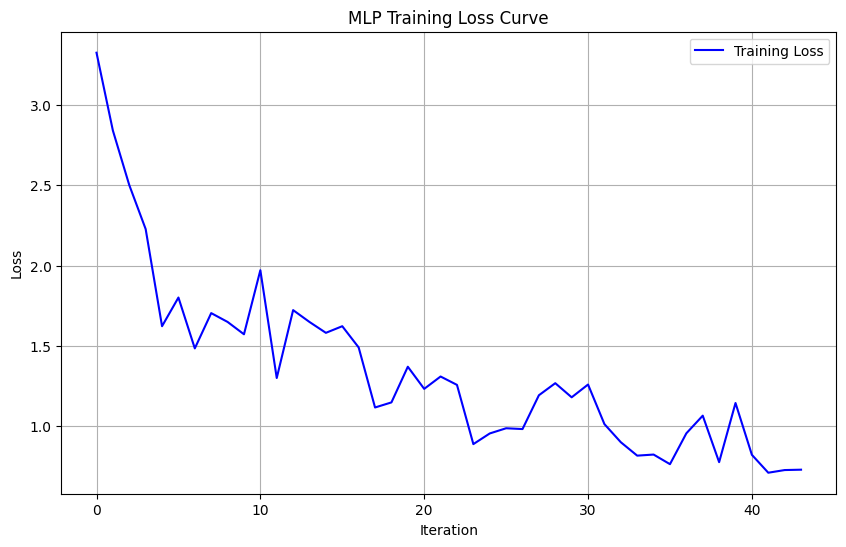

/tmp/ipykernel_27616/1937764261.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(cv_scores_mlp) + 1)), y=cv_scores_mlp, palette='viridis')


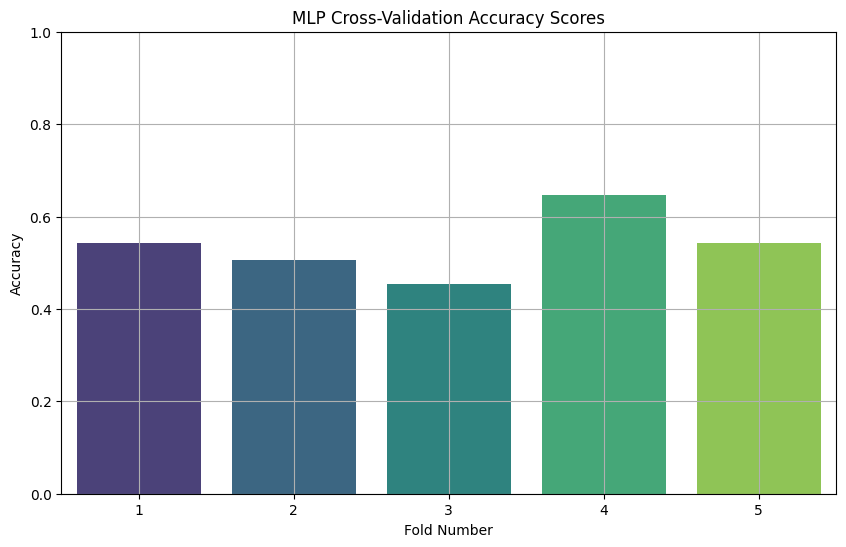

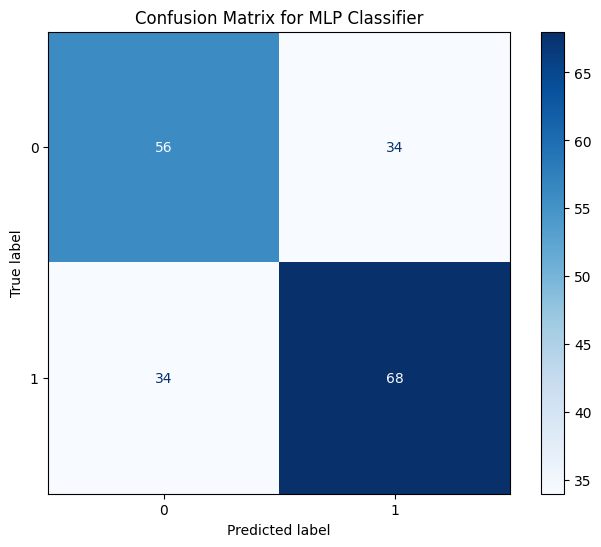

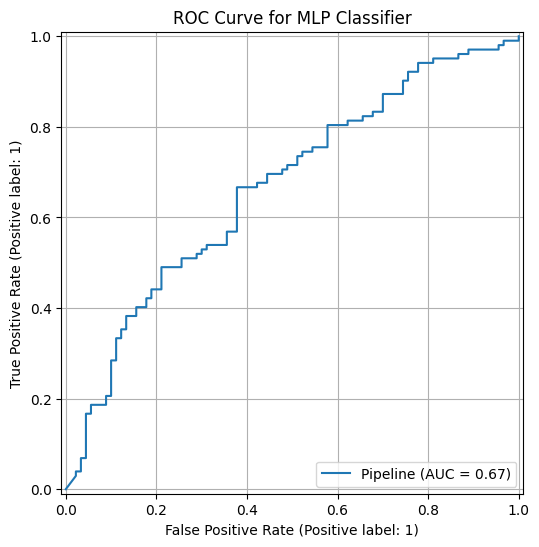

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting the training loss curve from the MLP model
if hasattr(mlp_model[-1], 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_model[-1].loss_curve_, label='Training Loss', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('MLP Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting cross-validation results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, len(cv_scores_mlp) + 1)), y=cv_scores_mlp, palette='viridis')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('MLP Cross-Validation Accuracy Scores')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Plotting confusion matrix for MLP predictions
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, ax=ax, cmap='Blues')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

# ROC Curve for MLP Classifier
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, ax=ax)
plt.title('ROC Curve for MLP Classifier')
plt.grid(True)
plt.show()


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance
import numpy as np

# Permutation Importance to find most informative voxels
result = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance = result.importances_mean

# Plotting voxel importance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(importance)), importance, marker='o', linestyle='-', color='purple')
plt.xlabel('Voxel Index')
plt.ylabel('Importance Score')
plt.title('Permutation Importance of Voxels for MLP Classification')
plt.grid(True)
plt.show()

KeyboardInterrupt: 